This notebook will explore model data at the Ocean Networks Canada(ONC) VENUS nodes. 

Information about the ONC VENUS nodes can be found here:
* http://venus.uvic.ca/

# Resources

We have lots of resources for working in Python. You can always look here for ideas, suggestions and more details.

* http://salishsea-meopar-docs.readthedocs.org/en/latest/work_env/python_notes.html


# Import Libraries

We need to import some tools for use in our notebooks. The first few lines below are libraries that are used in many of our notebooks. They are developed by the Python community.

That last few lines are developed in house and reflect commonly needed tasks in our group.  The source code is stored in tools/SalishSeaTools/salishsea_tools/



In [1]:
#Python
import matplotlib.pyplot as plt
import numpy as  np
import datetime
import netCDF4 as nc
from dateutil import tz

#in-house
from salishsea_tools import (viz_tools,tidetools,nc_tools)
from salishsea_tools.nowcast import (analyze,figures,research_VENUS)


%matplotlib inline

# Plot Map

Where are the VENUS nodes? Plot them on the model map. 
* We have a function that loads temperature and salinity data from either the central or east node.
    * figures.load_VENUS('Central') or figures.load_VENUS('East')
    * Documentation: http://salishsea-meopar-tools.readthedocs.org/en/latest/SalishSeaTools/nowcast.html#module-nowcast.figures
    * This function returns the temperature and salinity data, as well as the longitude, latitude and depth of the node

Central depth: 300 (m)
East depth: 170 (m)


1.1363636363636362

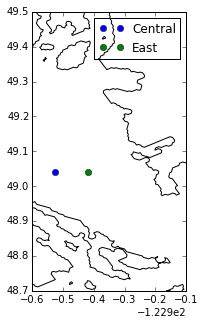

In [2]:
#load an example file to grab model_depths
T = nc.Dataset('/data/dlatorne/MEOPAR/SalishSea/nowcast/01feb15/SalishSea_1d_20150201_20150201_grid_T.nc')
model_depths = T.variables['deptht'][:]

#load model grid
fB= nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
Y = fB.variables['nav_lat'][:]
X = fB.variables['nav_lon'][:]
bathy = fB.variables['Bathymetry'][:]

#load VENUS at and plot position
datas={}; lons={}; lats={}; depths={};
for key in ('Central','East'):
    datas[key] = research_VENUS.load_VENUS(key)
    lons[key] = research_VENUS.SITES['VENUS'][key]['lon']
    lats[key] = research_VENUS.SITES['VENUS'][key]['lat']
    depths[key] = research_VENUS.SITES['VENUS'][key]['depth']
    datas[key][['sal','temp']]=datas[key][['sal','temp']].astype(float)

#plotting
fig,ax=plt.subplots(1,1,figsize=(5,5))
viz_tools.plot_coastline(ax,fB,coords='map')
for key in ('Central','East'): 
    ax.plot(lons[key],lats[key],'o',label=key)
    print key, 'depth:', depths[key], '(m)'

    ax.set_xlim([-123.5,-123])
ax.set_ylim([48.7,49.5])
ax.legend(loc=0)
viz_tools.set_aspect(ax)



# Compare model and observations

In [3]:
def truncate(data, t_o,t_f):
    #truncate a data between times t_o and t_f
    sdt=t_o.replace(tzinfo=tz.tzutc()); edt=t_f.replace(tzinfo=tz.tzutc())
    data_trun = data[(data.date< edt) & (data.date >sdt)]
    return data_trun



In [4]:
def compare_model_VENUS(station,start_time, end_time):
    """ function to compare model tmperature and salinity data with 
    VENUS observation over start_time and end_time.
    Station specifies 'East' or 'Central'
    start_time and end_time are datetime objects
    returns mean and standard deviation of model and observations and a figure.
    """
    
    #VENUS observations already loaded. But truncat over plotting tim
    data_trun = truncate(datas[station],start_time,end_time)
    
    #look up grid points that correspond to VENUS nodes
    k = tidetools.find_model_level(depths[station],model_depths)
    [j,i] = tidetools.find_closest_model_point(lons[station],lats[station],X,Y,bathy)

    #load model data
    fnames = analyze.get_filenames(start_time,end_time,'1h', 'grid_T','/data/dlatorne/MEOPAR/SalishSea/nowcast/')
    sal, time = analyze.combine_files(fnames,'vosaline',k,j,i) 
    temp, time = analyze.combine_files(fnames,'votemper',k,j,i)
    
    #plotting
    #salinity
    fig,axs= plt.subplots(2,1,figsize=(15,10))
    ax=axs[0]
    ax.plot(time,sal,label='model')
    ax.plot(data_trun.date[:],data_trun.sal[:],'-',label='obs')
    ax.set_xlim([start_time,end_time])
    ax.legend(loc=0)
    ax.set_title('Salinity comparison -  VENUS {}'.format(station))
    ax.set_ylabel('Salinty [PSU]')
    #temperature
    ax=axs[1]
    ax.plot(time,temp,label='model')
    ax.plot(data_trun.date[:],data_trun.temp[:],'-',label='obs')
    ax.set_xlim([start_time,end_time])
    ax.legend(loc=0)
    ax.set_title('Temp. comparison - VENUS {}'.format(station))
    ax.set_ylabel('Temperature (deg C)')
    
    #statistics
    means={'sal': {},'temp':{}}; stds={'sal':{},'temp':{}}
    means['sal']['obs']=  data_trun.sal.mean(); stds['sal']['obs']=data_trun.sal.std()
    means['temp']['obs']=  data_trun.temp.mean(); stds['temp']['obs']=data_trun.temp.std()
    means['sal']['model']=  np.mean(sal); stds['sal']['model']=np.std(sal)
    means['temp']['model']=  np.mean(temp); stds['temp']['model']=np.std(temp)
    
    return fig,means,stds


Observed Salinity: Mean 30.5487511905, std 0.165290890391
Modelled Salinity: Mean 30.0663248857, std 0.134890565242
Observed Temperature: Mean 8.98297827381, std 0.0657829209655
Modelled Temperature: Mean 9.721715996, std 0.0362036430265


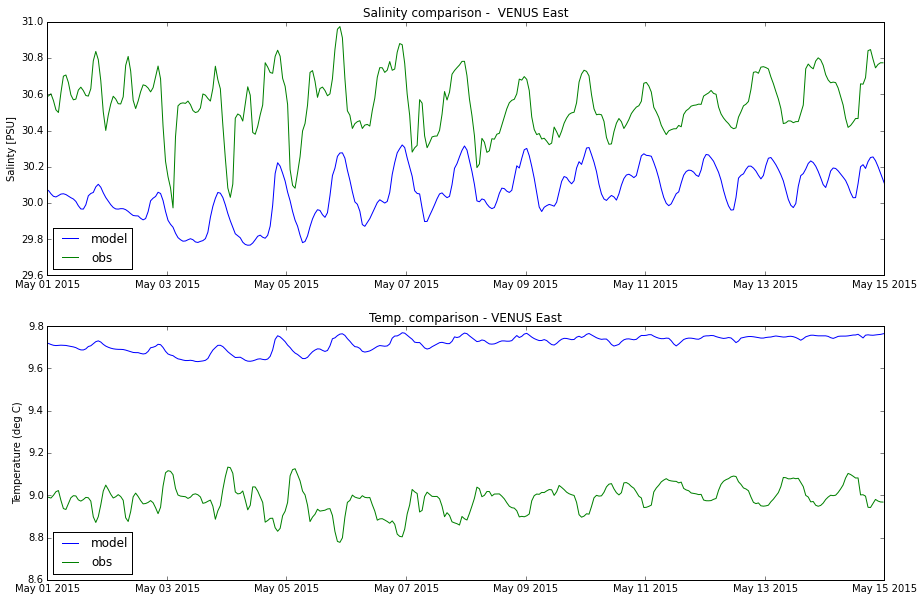

In [5]:
start_time=datetime.datetime(2015,5,1)
end_time=datetime.datetime(2015,5,15)

fig,means,stds=compare_model_VENUS('East',start_time,end_time)

print 'Observed Salinity: Mean {}, std {}'.format(means['sal']['obs'], stds['sal']['obs'])    
print 'Modelled Salinity: Mean {}, std {}'.format(means['sal']['model'], stds['sal']['model'])
    
print 'Observed Temperature: Mean {}, std {}'.format(means['temp']['obs'], stds['temp']['obs'])    
print 'Modelled Temperature: Mean {}, std {}'.format(means['temp']['model'], stds['temp']['model'])

Observed Salinity: Mean 31.0380089286, std 0.0833436778424
Modelled Salinity: Mean 30.4743744479, std 0.0161718038149
Observed Temperature: Mean 9.08620833333, std 0.157824214103
Modelled Temperature: Mean 9.75007368724, std 0.00486787913094


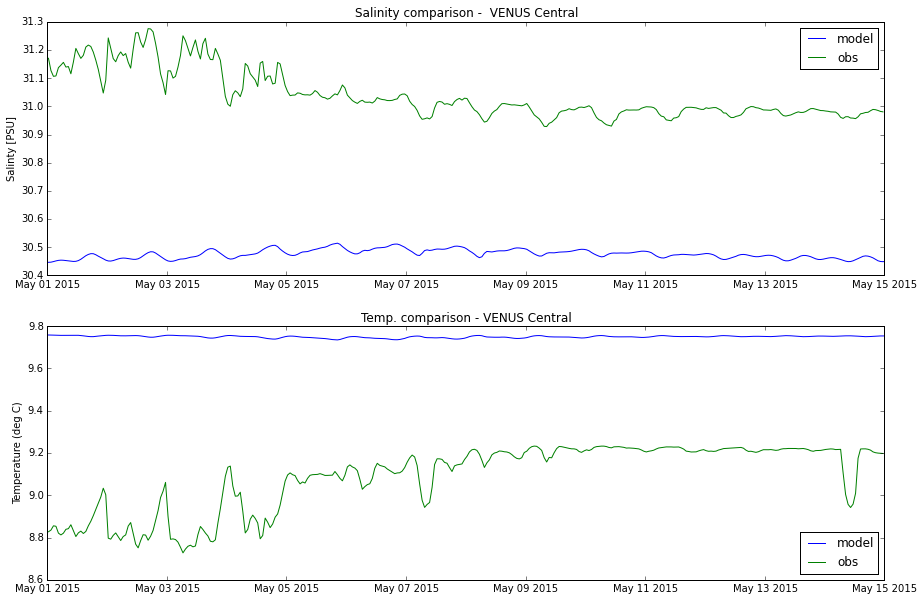

In [6]:
fig,means,stds=compare_model_VENUS('Central',start_time,end_time)

    
print 'Observed Salinity: Mean {}, std {}'.format(means['sal']['obs'], stds['sal']['obs'])    
print 'Modelled Salinity: Mean {}, std {}'.format(means['sal']['model'], stds['sal']['model'])
    
print 'Observed Temperature: Mean {}, std {}'.format(means['temp']['obs'], stds['temp']['obs'])    
print 'Modelled Temperature: Mean {}, std {}'.format(means['temp']['model'], stds['temp']['model'])

Questions
1. What improvements can we make to these plots?
2. How else can we compare model with observations?

# Profiles over depth

We've recently started saving model data at the VENUS nodes every 15 minutes. Let's import and plot temperaure and salinty depth profiles over time.

In [7]:
def combine(files, var):
    """function to combine a model variable from a list of many files. 
    Returns an array of the variabel and associated model times.
    Suitable for use with the VENUS_east.nc and VENUS_central.nc files.
    Only for variables over depth.
    """
    #empty arrays
    time = np.array([])
    var_list=[]

    for f in files:
        G = nc.Dataset(f)
        var_tmp = G.variables[var][:,:,0,0]
        #append variable to array
        var_list.append(var_tmp)
        t = nc_tools.timestamp(G, np.arange(var_tmp.shape[0]))
        for ind in range(len(t)):
            t[ind] = t[ind].datetime
        time = np.append(time, t)
        
    var_ary=np.concatenate(var_list,axis=0)
    return var_ary,time

The VENUS files are either VENUS_east.nc or VENUS_central.nc. Make a list and sort them in chronological order.

In [8]:
import glob
import os

path = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
files = glob.glob(os.path.join(path,'*','*_1h_*_grid_T*'))
    
files = []
files_East = glob.glob(os.path.join(path,'*','VENUS_east.nc'))
for f in files_East:
    directory=os.path.dirname(f)
    files.append(glob.glob(os.path.join(directory,'*_1h_*_grid_T*'))[0])
files.sort(key=os.path.basename)

files_East = [];
files_Central=[];
for f in files:
    directory=os.path.dirname(f)
    files_East.append(os.path.join(directory,'VENUS_east.nc'))
    files_Central.append(os.path.join(directory,'VENUS_central.nc'))

Now grab the temperatude and salinity data.

In [9]:
temps={}
sals={}
temps['East'],time=combine(files_East,'votemper')
sals['East'],time=combine(files_East,'vosaline')
temps['Central'],time=combine(files_Central,'votemper')
sals['Central'],time=combine(files_Central,'vosaline')

Plotting the time series next

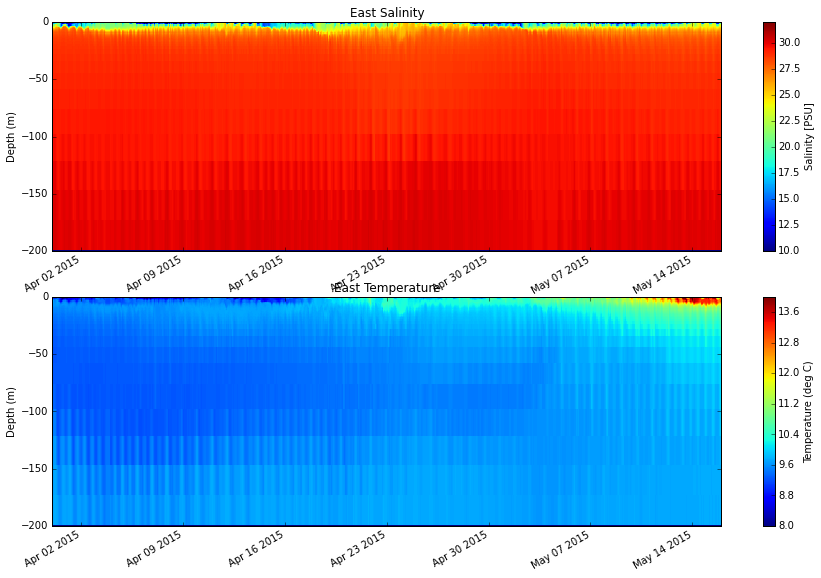

In [10]:
#plot East node time seres
key='East'
fig,axs=plt.subplots(2,1,figsize=(15,10))
ax=axs[0]
mesh=ax.pcolormesh(time,-model_depths,sals[key].T,vmin=10,vmax=32)
cbar=plt.colorbar(mesh,ax=ax)
ax.set_title('{} Salinity'.format(key))
cbar.set_label('Salinity [PSU]')    

ax=axs[1]
mesh=ax.pcolormesh(time,-model_depths,temps[key].T,vmin=8,vmax=14)
cbar=plt.colorbar(mesh,ax=ax)
ax.set_title('{} Temperature'.format(key))
cbar.set_label('Temperature (deg C)')  

for ax in axs:
    ax.xaxis_date()
    ax.set_ylim([-200,0])
    ax.set_ylabel('Depth (m)')
fig.autofmt_xdate()

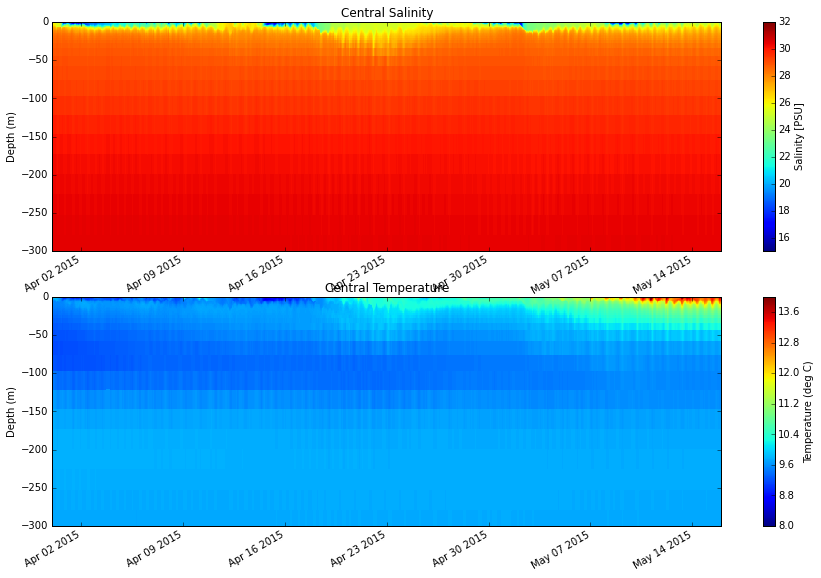

In [11]:
#plot Central node time seres
key='Central'
fig,axs=plt.subplots(2,1,figsize=(15,10))
ax=axs[0]
mesh=ax.pcolormesh(time,-model_depths,sals[key].T,vmin=15,vmax=32)
cbar=plt.colorbar(mesh,ax=ax)
ax.set_title('{} Salinity'.format(key))
cbar.set_label('Salinity [PSU]')    

ax=axs[1]
mesh=ax.pcolormesh(time,-model_depths,temps[key].T,vmin=8,vmax=14)
cbar=plt.colorbar(mesh,ax=ax)
ax.set_title('{} Temperature'.format(key))
cbar.set_label('Temperature (deg C)')  

for ax in axs:
    ax.xaxis_date()
    ax.set_ylim([-300,0])
    ax.set_ylabel('Depth (m)')
fig.autofmt_xdate()

Questions
1. How can we improve these plots?
2. Do you notice anything interesting? What other information would help you explain some of the trends in these plots?

# What's next?

Here are a few things to try.

1. Think of ways to improve the above plots. 
2. Plot the current speed vs depth over time. How can we compare this with observations? 
3. Read through this notebook where Susan calculated tidal ellipses using output from an early simulation. Start thinking about how we can redo the tidal ellipse calculations at the VENUS East and Central nodes with more recent model data.


* http://nbviewer.ipython.org/urls/bitbucket.org/salishsea/analysis/raw/tip/compare_tides/Ellipses.ipynb